# Basic Example

## Data import

The first step of data analysis is import data. In this code, data import is always handled through an instance of the [DataLoaders](https://bwheelz36.github.io/ParticlePhaseSpace/code_docs.html#module-ParticlePhaseSpace.DataLoaders) class. In this example, we will work with topas data. For a list of all currently available data importers, see [here](https://bwheelz36.github.io/ParticlePhaseSpace/code_docs.html#module-ParticlePhaseSpace.DataLoaders); for instructions on writing new data importers see [here](https://bwheelz36.github.io/ParticlePhaseSpace/new_data_loader.html)

In [1]:
from pathlib import Path
import sys
sys.path.append('../')  # not necessary when the library is installed
from ParticlePhaseSpace import DataLoaders
from ParticlePhaseSpace import PhaseSpace

test_data_loc = Path(r'../tests/test_data/coll_PhaseSpace_xAng_0.00_yAng_0.00_angular_error_0.0.phsp').absolute()
ps_data = DataLoaders.Load_TopasData(test_data_loc)

Once we have a DataLoader instance, we can pass it  to ParticlePhaseSpace for analysis:

In [2]:
PS = PhaseSpace(ps_data)

## Basic analytics

Once we have an instance of ParticlePhaseSpace, we can perform some analysis.

In [3]:
PS.print_energy_stats()

                 ENERGY STATS                  
total number of particles in phase space:  311489
number of unique particle species:  3
     308280 gammas
        mean energy:  1.91 MeV
        median energy:  1.20 MeV
        Energy spread IQR:  2.03 MeV
        min energy  0.01 MeV
        max energy  10.35 MeV
     2853 electrons
        mean energy:  3.16 MeV
        median energy:  3.39 MeV
        Energy spread IQR:  2.95 MeV
        min energy  0.02 MeV
        max energy  9.44 MeV
     356 positrons
        mean energy:  2.66 MeV
        median energy:  2.39 MeV
        Energy spread IQR:  2.39 MeV
        min energy  0.08 MeV
        max energy  8.46 MeV


You can see that this phase space consists of three different particle species.
We can also generate plots for energy, and particle positions:

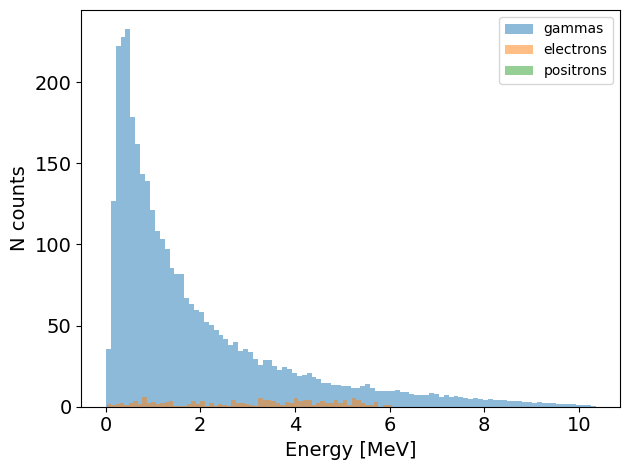

In [4]:
PS.plot_energy_histogram()

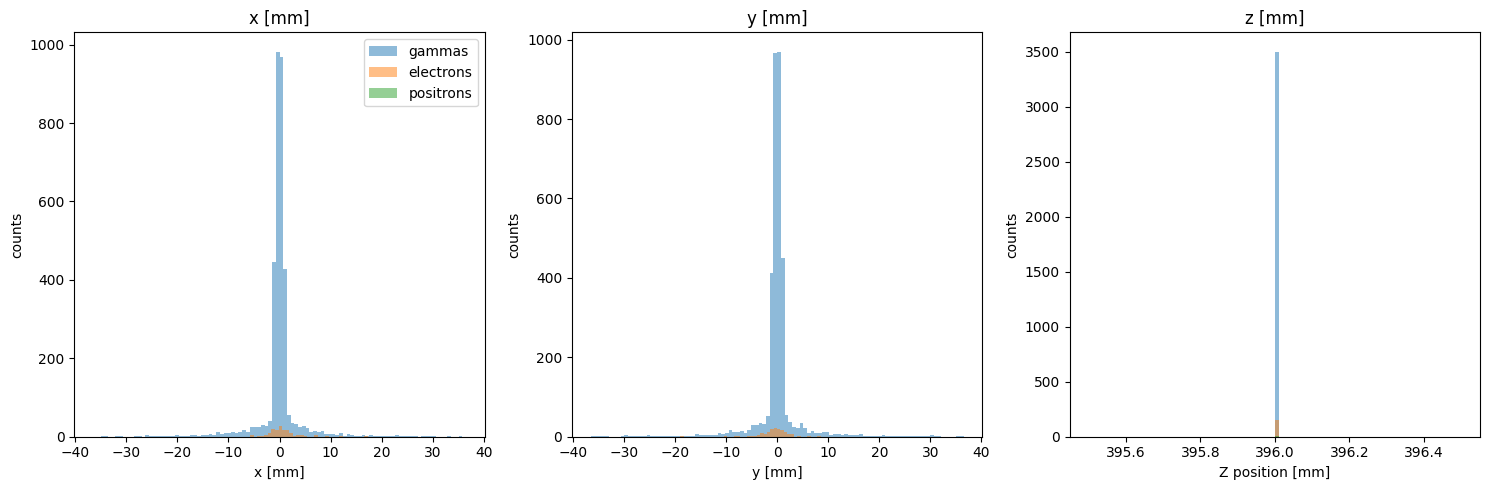

In [5]:
PS.plot_position_histogram()

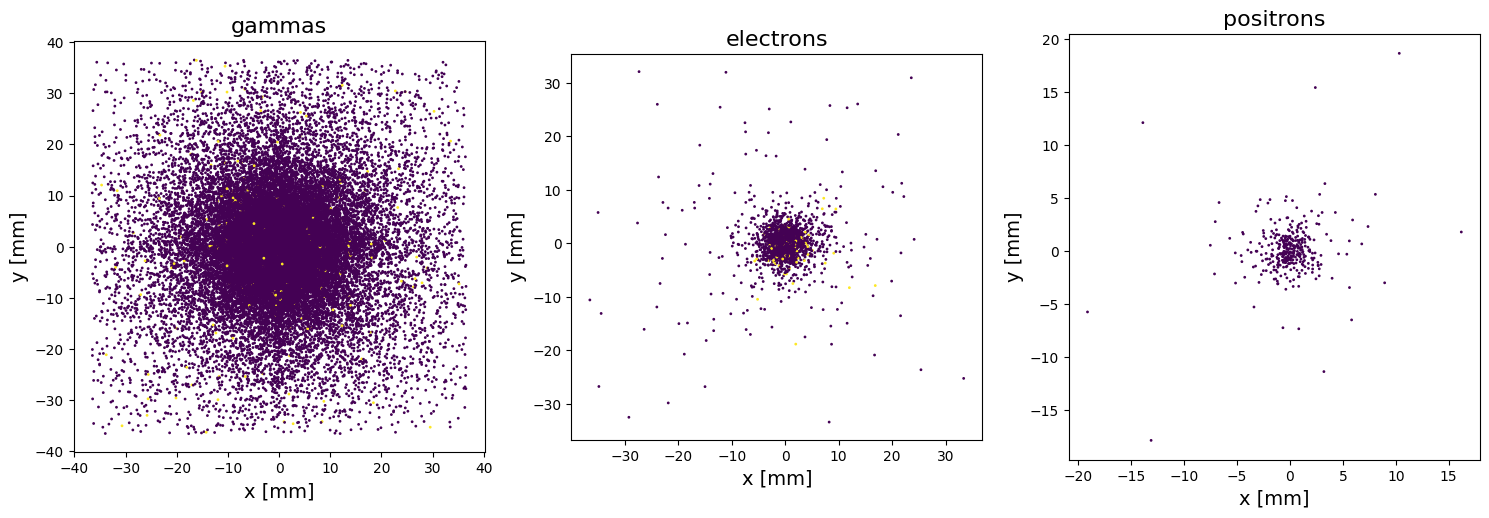

In [6]:
PS.plot_particle_positions(beam_direction='z')

Note that in the plot above, particles with different weights are plotted with different colors.
Another way to visualise the particle positions is the `plot_beam_intensity` method, which will produce an image of accumulated intensity:

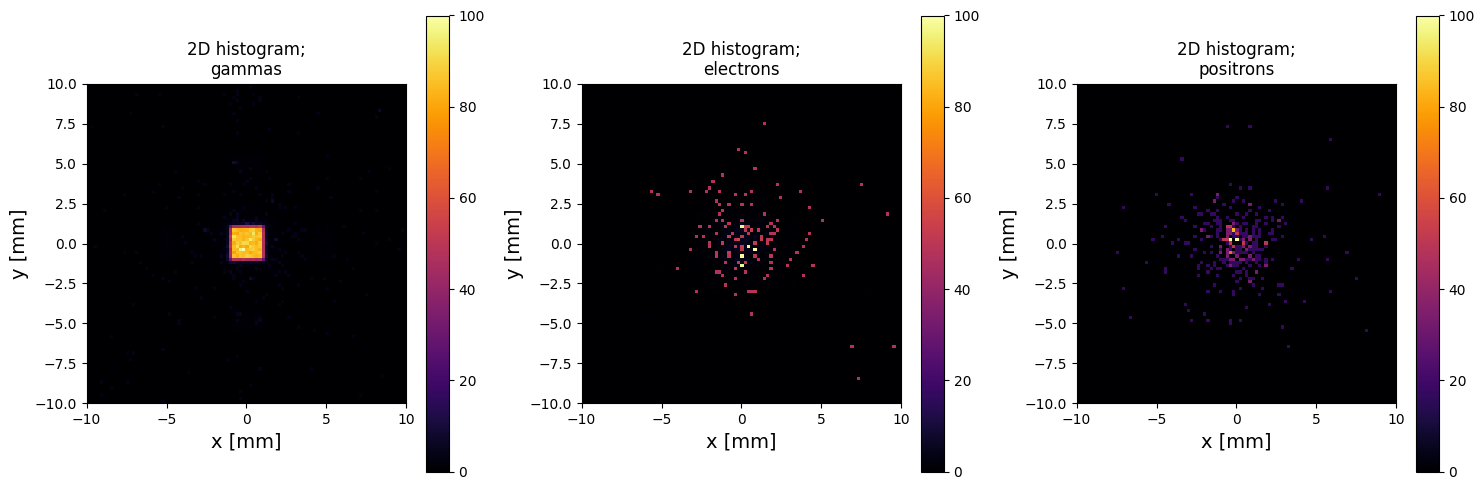

In [7]:
PS.plot_beam_intensity(xlim=[-10, 10], ylim=[-10,10], grid=False)

This plot is actually a lot more illuminating than the scatter plot in this instance!
This phase space was scored at the exit of a [novel type of x-ray collimator](https://aapm.onlinelibrary.wiley.com/doi/10.1002/mp.15887); you can see that the x-rays (gammas) have been shaped to a square, which is as expected. Meanwhile the electrons and positrons are randomly scattered, which is also as expected.

## Seperating, adding, and subtracting phase space objects

You can easily add, subtract, and seperate phase space objects:

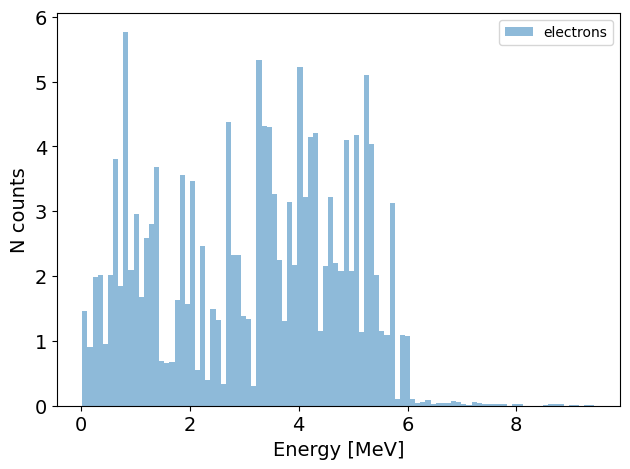

In [8]:
electron_PS = PS('electrons')  # this generates a phase space with only the electrons
# you can also use pdg codes:
electron_PS = PS(11)  # this is the same
electron_PS.plot_energy_histogram()

You can also pass a list of particles to get multiple phase spaces at once:

In [9]:
gamma_PS, positron_PS = PS(['gammas', 'positrons'])  # you can also pass a list

You can subtract one phase space from another. For example, the following will produce a new phase space object where all the gamma particles are removed:

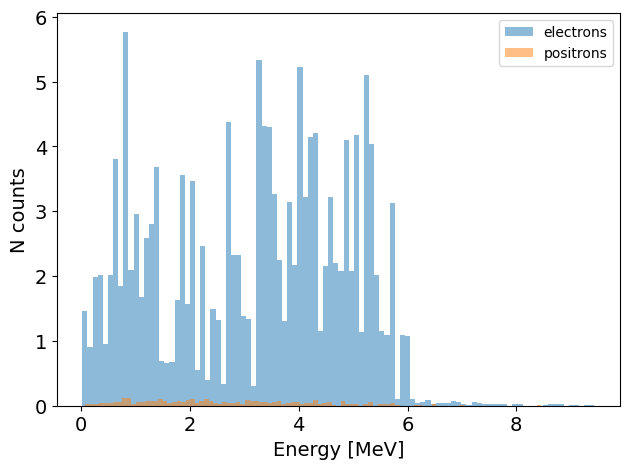

In [10]:
no_gamma_PS = PS - gamma_PS
no_gamma_PS.plot_energy_histogram()

You can also add phase spaces together:

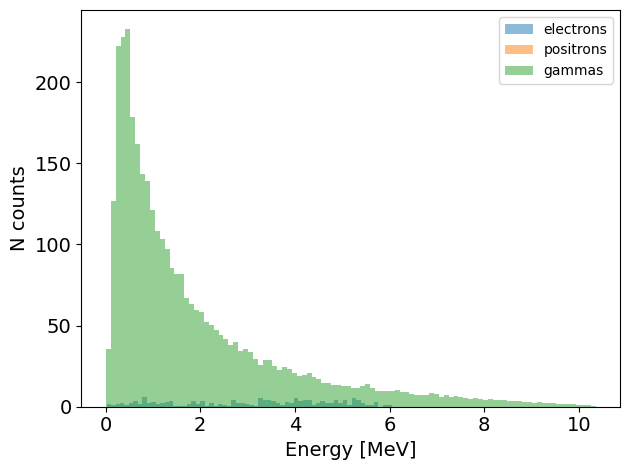

In [11]:
Original_PS = no_gamma_PS + gamma_PS
Original_PS.plot_energy_histogram()

However: you cannot add identical particles into an existing phase space. If you really want to do this, you will need to update the particle_ID field first.

## Twiss parameters

[Twiss parameters](https://en.wikipedia.org/wiki/Courant%E2%80%93Snyder_parameters) or courant-snyder parameters are commonly used to describe the distribution of particles in a transverse phase space. You can calculate, save, and plot the twiss parameters:

In [12]:
PS.print_twiss_parameters(beam_direction='z')  # calculate the RMS twiss parameters

                 TWISS PARAMETERS                  

gammas:
                x         y
epsilon  2.525901  2.673361
alpha    0.619585  0.525727
beta     8.976938  9.488084
gamma    0.154160  0.134526

electrons:
                x         y
epsilon  2.208669  2.357446
alpha    1.159332  1.009164
beta     4.971102  4.634599
gamma    0.471535  0.435510

positrons:
                x         y
epsilon  1.881200  1.178092
alpha    1.141023  2.283977
beta     3.888975  5.672388
gamma    0.591913  1.095932


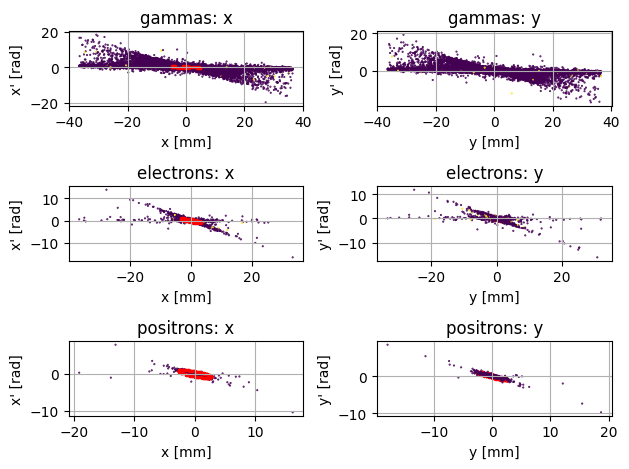

In [13]:
PS.plot_transverse_trace_space_scatter()

The above plot shows what is sometimes called a 'trace space' which is plot of position (x) versus divergence (x' = px/pz). The Red ellipse represents the space enclosed by the RMS twiss parameters, which should enclode 37% of the beam. As an alternative to the scatter plot, you can also visualise the intensity (defined as the sum of weights) in trace space: 




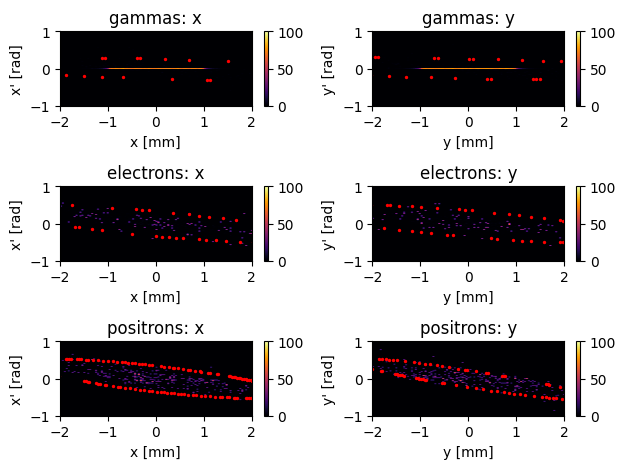

In [17]:
PS.plot_transverse_trace_space_intensity(xlim=[-2,2], ylim=[-1, 1], plot_twiss_ellipse=True, grid=False)

Again, this is quite illuminating; it shows that the gamma particles are fairly evenly dsitributed spread between -1 and 1 mm, and have almost no divergence. Again, since this data is from an x-ray collimator, this makes a lot of sense!

## Manipulating data in the phase space

For some research purposes you may wish to manipulate the data in the phase space - for instance, change the z value of all particles because different simulation codes use different coordinate system.

This is very possible with this code; you can directly change all data fields by directly interacting with the pandas data stored at `PhaseSpace.ps_data`. 

**HOWEVER!**
- you do this at your own risk, since there is no way for us to check the validity of any operations you make
- following any edits to the underling data, you should manually `reset_phase_space`, because you have quite likely invalidated any previously calculated quantities. [`reset_phase_space`](https://bwheelz36.github.io/ParticlePhaseSpace/code_docs.html#ParticlePhaseSpace._ParticlePhaseSpace.PhaseSpace.reset_phase_space) removes any calculated data from the phase space, reducing it to just the [required columns](https://bwheelz36.github.io/ParticlePhaseSpace/phase_space_format.html)

In [18]:
# zero the z coordinate
PS.ps_data['z [mm]'] = PS.ps_data['z [mm]'] - PS.ps_data['z [mm]'].mean()
# double the pz momentum:
PS.ps_data['pz [MeV/c]'] = PS.ps_data['pz [MeV/c]'] * 2
# reset the phase space because previous calculations are now invalid:
PS.reset_phase_space()
# re-calculate any desired quantities
PS.fill_kinetic_E()  # for example

## Exporting the data

Similarly to the data import stage we use an instance of `ParticlePhaseSpace.DataLoaders` to export the data.
You can see the currently available data exporters [here](https://bwheelz36.github.io/ParticlePhaseSpace/code_docs.html#module-ParticlePhaseSpace.DataExporters), and you see a demonstration of writing a new data exporter [here](https://bwheelz36.github.io/ParticlePhaseSpace/new_data_exporter.html). At the time of writing, I had only written the topas exporter, so again this is what I will use in this example:

In [19]:
from ParticlePhaseSpace import DataExporters

DataExporters.Topas_Exporter(PS, output_location=Path('.'), output_name='test_export')

generating topas data file
success
